# **Lezione 11**

### **Exercise 11.1**

Lo scopo di questo esercizio è esercitarsi con la rete neurale, esplorando come una regressione lineare della funzione $ f(x)=2x+1 $, dipende dal numero di epoche, $N_{epochs}$, dal numero di punti di training $N_{train}$ e dal rumore $\sigma$. In questo esercizio mi sono dunque concentrato nella semplice variazione di questi parametri senza indagare la struttura della rete neurale stessa, cosa che farò nell'esercizio seguente. 

Iniziamo definendo i set di parametri che andremo a variare e allenare la rete neurale, tutti scelti per andare a coprire un buon range, comprendendo anche quelli dati nella consegna.

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import matplotlib.pyplot as plt
import numpy as np
import itertools
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
from keras import Input
from keras.utils import get_custom_objects

sigma_list = [0.1, 0.3, 0.5, 1]
N_train_list = [100, 300, 500, 1000]
N_epochs_list = [10, 30, 50, 100]

def f(x, m=2, b=1):
    return m*x + b

Dunque partendo dalla rete neurale data dalla consegna andiamo a definire una funzione che mi crea, allena e valuta un modello a dati parametri:

In [4]:
def do_everything(sigma, N_train, N_epochs, N_valid=50):

    np.random.seed(1)
    tf.random.set_seed(1)
    x_train = np.random.uniform(-1, 1, N_train)
    x_valid = np.random.uniform(-1, 1, N_valid) 
    x_valid.sort()

    y_train = np.random.normal(f(x=x_train), sigma)
    y_valid = np.random.normal(f(x=x_valid), sigma)

    model = Sequential()
    model.add(Dense(1, input_shape=(1,)))
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    model.fit(x=x_train, y=y_train, 
          batch_size=4, epochs=N_epochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid), 
          verbose=0)
    score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=0)

    return score[0] # ie la loss


param_combinations = list(itertools.product(sigma_list, N_epochs_list, N_train_list))
losses = []

# Esecuzione modello su tutte le combinazioni
for sigma, n_epochs, n_train in param_combinations:
    loss = do_everything(sigma, n_train, n_epochs)
    losses.append(loss)


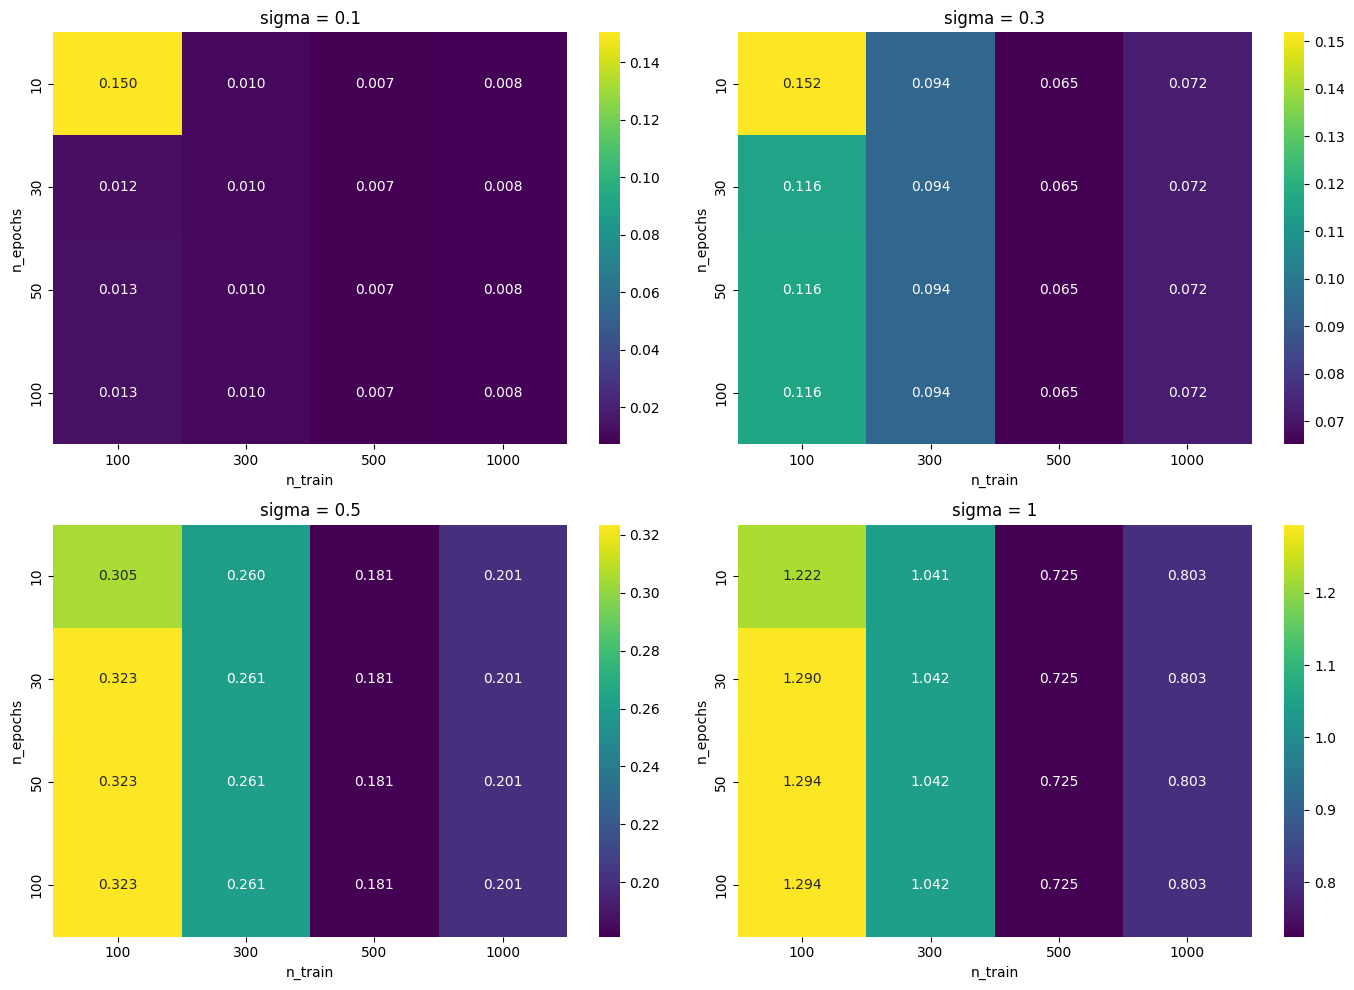

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(param_combinations, columns=['sigma', 'n_epochs', 'n_train'])
df['loss'] = losses

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # griglia 2x2
axes = axes.flatten()  # per iterare facilmente

for i, sigma_val in enumerate(sigma_list):
    subset = df[df['sigma'] == sigma_val]
    pivot = subset.pivot(index='n_epochs', columns='n_train', values='loss')
    
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis", ax=axes[i])
    axes[i].set_title(f"sigma = {sigma_val}")
    axes[i].set_xlabel('n_train')
    axes[i].set_ylabel('n_epochs')

plt.tight_layout()
plt.show()


Da questi grafici possiamo trarre delle importanti informazioni:
1. Innanzitutto vediamo subito che la loss aumenta all'aumentare del rumore $\sigma$, come ci si può facilmente aspettare.

2. Guardando invece l'andamento della loss in funzione del numero di epoche, a fissato rumore e campione di training, vediamo che questa diminuisce nel passaggio da 10 a 30 epoche e poi resta pressoché costante. Da ciò possiamo dedurre che dopo un numero ristretto di epoche il modello converge, per poi rimanere invariato.

3. Mentre a fissato rumore e numero di epoche osserviamo che all'aumentare del campione di training non corrisponde per forza una diminuzione della loss. Infatti da $N_{train} = 500 \rightarrow 1000$ osserviamo un aumento della loss, comportamento interpretabile come un overfitting del modello che produce dunque una predizione peggiore.


Dunque i paramentri migliori tra quelli indagati per il fitting della funzione con questa NN sono:
- $\sigma$ il più basso possibile
- $N_{train}$ = 500, oltre cui andiamo in overfitting
- $N_{epochs}$ = 30, sufficienti a saturare il modello